In [1]:
import numpy as np
import gymnasium as gym
from copy import deepcopy
import random
import matplotlib.pyplot as plt

In [2]:
# Constants
GAME_NAME = 'CartPole-v1'
MCTS_POLICY_EXPLORE = 20  # Reduced for faster testing
C = 1.0  # Exploration constant

# Initialize environment
env = gym.make(GAME_NAME)
GAME_ACTIONS = env.action_space.n
GAME_OBS = env.observation_space.shape[0]

print(f"In the {GAME_NAME} environment:")
print(f"- Possible actions: {GAME_ACTIONS}")
print(f"- Observation space: {GAME_OBS} values")

In the CartPole-v1 environment:
- Possible actions: 2
- Observation space: 4 values


In [3]:
class Node:
    def __init__(self, game, done, parent, observation, action_index):
        self.child = None
        self.T = 0  # Total reward
        self.N = 0  # Visit count
        self.game = deepcopy(game)  # Avoid modifying the original env
        self.observation = observation
        self.done = done
        self.parent = parent
        self.action_index = action_index

    def getUCBscore(self):
        if self.N == 0:
            return float('inf')
        parent_visits = self.parent.N if self.parent else self.N
        return (self.T / self.N) + C * np.sqrt(np.log(parent_visits) / self.N)

    def detach_parent(self):
        if self.parent:
            del self.parent
            self.parent = None

    def create_child(self):
        if self.done:
            return
        self.child = {}
        for action in range(GAME_ACTIONS):
            new_game = deepcopy(self.game)
            obs, reward, done, truncated, info = new_game.step(action)
            self.child[action] = Node(new_game, done, self, obs, action)

    def explore(self):
        current = self
        # Traverse tree to leaf
        while current.child:
            max_U = max(child.getUCBscore() for child in current.child.values())
            best_actions = [a for a, child in current.child.items() if child.getUCBscore() == max_U]
            action = random.choice(best_actions)
            current = current.child[action]

        # Rollout or expand
        if current.N < 1:
            current.T += current.rollout()
        else:
            current.create_child()
            if current.child:
                current = random.choice(list(current.child.values()))
            current.T += current.rollout()
        current.N += 1

        # Backpropagate
        parent = current
        while parent.parent:
            parent = parent.parent
            parent.N += 1
            parent.T += current.T

    def rollout(self):
        if self.done:
            return 0
        total_reward = 0
        new_game = deepcopy(self.game)
        done = False
        while not done:
            action = new_game.action_space.sample()
            obs, reward, done, truncated, info = new_game.step(action)
            total_reward += reward
            if done or truncated:
                break
        return total_reward

    def next(self):
        if self.done:
            raise ValueError("Game has ended")
        if not self.child:
            raise ValueError("No children found")
        max_N = max(child.N for child in self.child.values())
        best_children = [child for child in self.child.values() if child.N == max_N]
        return random.choice(best_children), random.choice(best_children).action_index

def Policy_Player_MCTS(mytree):
    for _ in range(MCTS_POLICY_EXPLORE):
        mytree.explore()
    next_tree, next_action = mytree.next()
    next_tree.detach_parent()
    return next_tree, next_action

In [4]:
# Training loop
episodes = 10
rewards = []
moving_avg = []

for e in range(episodes):
    game = gym.make(GAME_NAME)
    obs, info = game.reset()
    mytree = Node(game, False, None, obs, 0)
    total_reward = 0
    done = False

    print(f"Episode #{e + 1}")
    while not done:
        mytree, action = Policy_Player_MCTS(mytree)
        obs, reward, done, truncated, info = game.step(action)
        total_reward += reward
        if done or truncated:
            game.close()
            break

    rewards.append(total_reward)
    moving_avg.append(np.mean(rewards[-10:]))
    print(f"Reward: {total_reward}")

Episode #1
Reward: 500.0
Episode #2
Reward: 499.0
Episode #3
Reward: 500.0
Episode #4
Reward: 471.0
Episode #5
Reward: 269.0
Episode #6
Reward: 496.0
Episode #7
Reward: 411.0
Episode #8
Reward: 349.0
Episode #9
Reward: 500.0
Episode #10
Reward: 500.0


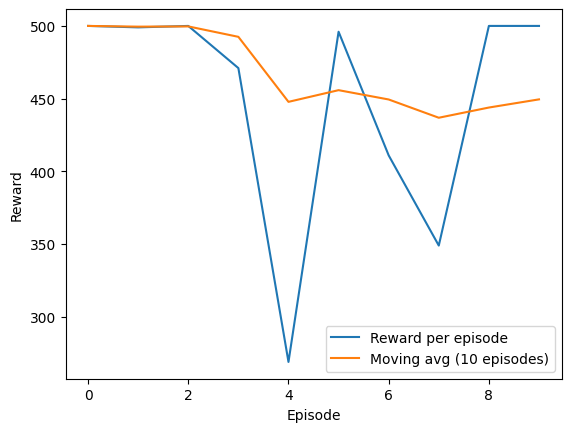

Final moving average: 449.5


In [5]:
# Plot results
plt.plot(rewards, label='Reward per episode')
plt.plot(moving_avg, label='Moving avg (10 episodes)')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()
print(f"Final moving average: {np.mean(rewards[-10:])}")


In [6]:

import networkx as nx
import matplotlib.pyplot as plt

def plot_mcts_tree(root):
    G = nx.DiGraph()
    node_labels = {}

    def add_nodes(node, parent_id=None):
        node_id = id(node)
        node_labels[node_id] = f"N={node.N}\nT={node.T:.1f}"
        G.add_node(node_id)
        if parent_id:
            G.add_edge(parent_id, node_id)
        if node.child:
            for action, child in node.child.items():
                add_nodes(child, node_id)

    add_nodes(root)
    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=1000, node_color='lightblue')
    plt.show()

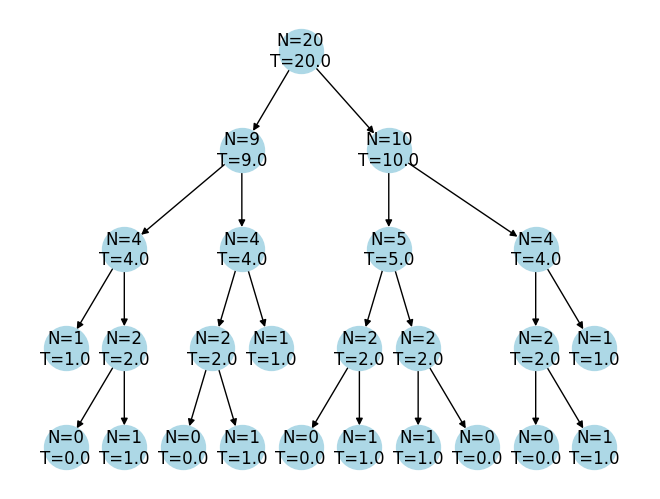

In [7]:
# Call this after some MCTS iterations
plot_mcts_tree(mytree)

There are 2 plots
1. shows the progress of the reward with respect to episode. For Cartpole, reward of 500 is considered to be completing the game. The reward is appended by +1 for every extra second the pole is held stable.
2. The second graph shows the expansion of the node vs the